# IMDB Sentiment Analysis

This notebook performs sentiment classification on the IMDB dataset (http://ai.stanford.edu/~amaas/data/sentiment/).

In [2]:
# Install required packages (run this cell if packages are missing in your kernel)
# Recommended: run in a GPU-enabled environment (Colab, or a local conda env with GPU drivers).
# For most systems:
%pip install --upgrade pip
%pip install tensorflow scikit-learn numpy

# If you're on macOS with Apple Silicon (M1/M2) you may instead use:
# %pip install tensorflow-macos tensorflow-metal scikit-learn numpy

print('If installation succeeded, re-run the notebook cells (imports and models).')

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 MB 17.8 MB/s  0:00:11m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 30.7 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 kB 15.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.3 MB/s  0:00:00
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 30.7 MB/s  0:00:00m0:00:0100:01
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [tensorflow]9 [tensorflow]]
Note: you may need to

In [4]:
# Imports and GPU check
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import time

# GPU detection
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('Using GPU for training (if available to TensorFlow).')
    except Exception as e:
        print('Could not set memory growth:', e)
else:
    print('No GPU detected - CPU will be used.')


GPUs found: []
No GPU detected - CPU will be used.


In [5]:
# Load IMDB dataset - keep top n words and pad sequences
top_n = 5000  # vocabulary size (keep top 5000 words)
maxlen = 500  # maximum review length (in words) - pad/truncate to this length
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=top_n)
print('Loaded IMDB: train samples=', len(x_train), 'test samples=', len(x_test))

# Pad sequences to the same length
x_train_pad = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
print('Padded shapes:', x_train_pad.shape, x_test_pad.shape)

# Get word index mapping for later decoding/stopword experiments
word_index = keras.datasets.imdb.get_word_index()
# Reserve indices: 0 (padding), 1 (start), 2 (unknown), 3 (unused) - same scheme Keras uses
index_to_word = {index+3: word for word, index in word_index.items()}
index_to_word[0] = '<PAD>'
index_to_word[1] = '<START>'
index_to_word[2] = '<UNK>'
index_to_word[3] = '<UNUSED>'

def decode_review(sequence):
    # Convert sequence of indices to words (ignoring unknown offsets)
    return ' '.join(index_to_word.get(i, '?') for i in sequence if i != 0)

# Quick sanity decode of first review
print('Example decoded review (truncated):')
print(decode_review(x_train[0])[:400])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Loaded IMDB: train samples= 25000 test samples= 25000
Loaded IMDB: train samples= 25000 test samples= 25000
Padded shapes: (25000, 500) (25000, 500)
Padded shapes: (25000, 500) (25000, 500)
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Example decoded review (truncated):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it
Example decoded review (truncated):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could

In [6]:
# Helper: build bag-of-words binary matrix from sequences for Logistic Regression
def sequences_to_bow(sequences, vocab_size):
    # sequences: list/array of lists of word indices (already limited by num_words)
    X = np.zeros((len(sequences), vocab_size), dtype=np.float32)
    for i, seq in enumerate(sequences):
        for idx in seq:
            if 0 < idx < vocab_size:
                X[i, idx] = 1.0
    return X

vocab_size = top_n  # indices range 1..top_n-1 (0 for padding)
X_train_bow = sequences_to_bow(x_train_pad, vocab_size)
X_test_bow = sequences_to_bow(x_test_pad, vocab_size)
print('BOW shapes:', X_train_bow.shape, X_test_bow.shape)

# 1) Logistic Regression on BOW features
print('\nTraining Logistic Regression (BOW) ...')
start = time.time()
lr = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)
lr.fit(X_train_bow, y_train)
y_pred_lr = lr.predict(X_test_bow)
acc_lr = accuracy_score(y_test, y_pred_lr) * 100.0
print(f'Logistic Regression accuracy: {acc_lr:.2f}% (time {time.time()-start:.1f}s)')


BOW shapes: (25000, 5000) (25000, 5000)

Training Logistic Regression (BOW) ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression accuracy: 85.74% (time 128.3s)


In [7]:
# 2) Feed-forward neural network using Embedding + GlobalAveragePooling
embedding_dim = 32
ffnn_epochs = 5
ffnn_batch = 512

model_ff = keras.Sequential([
    layers.Embedding(input_dim=top_n, output_dim=embedding_dim, input_length=maxlen),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_ff.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ff.summary()

start = time.time()
model_ff.fit(x_train_pad, y_train, epochs=ffnn_epochs, batch_size=ffnn_batch, validation_split=0.1, verbose=2)
loss, acc = model_ff.evaluate(x_test_pad, y_test, verbose=0)
print(f'Feed-forward NN accuracy: {acc*100:.2f}% (time {time.time()-start:.1f}s)')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
44/44 - 3s - 60ms/step - accuracy: 0.5164 - loss: 0.6919 - val_accuracy: 0.4900 - val_loss: 0.6891
Epoch 2/5
44/44 - 3s - 60ms/step - accuracy: 0.5164 - loss: 0.6919 - val_accuracy: 0.4900 - val_loss: 0.6891
Epoch 2/5
44/44 - 1s - 27ms/step - accuracy: 0.5842 - loss: 0.6795 - val_accuracy: 0.6060 - val_loss: 0.6634
Epoch 3/5
44/44 - 1s - 27ms/step - accuracy: 0.5842 - loss: 0.6795 - val_accuracy: 0.6060 - val_loss: 0.6634
Epoch 3/5
44/44 - 1s - 27ms/step - accuracy: 0.6466 - loss: 0.6478 - val_accuracy: 0.7496 - val_loss: 0.6159
Epoch 4/5
44/44 - 1s - 27ms/step - accuracy: 0.6466 - loss: 0.6478 - val_accuracy: 0.7496 - val_loss: 0.6159
Epoch 4/5
44/44 - 1s - 29ms/step - accuracy: 0.7316 - loss: 0.5912 - val_accuracy: 0.7888 - val_loss: 0.5484
Epoch 5/5
44/44 - 1s - 29ms/step - accuracy: 0.7316 - loss: 0.5912 - val_accuracy: 0.7888 - val_loss: 0.5484
Epoch 5/5
44/44 - 1s - 25ms/step - accuracy: 0.7627 - loss: 0.5302 - val_accuracy: 0.8208 - val_loss: 0.4875
44/44 - 1s - 25ms/s

In [8]:
# 3) Convolutional 1D Neural Network (>=3 Conv1D + MaxPool blocks)
conv_epochs = 6
conv_batch = 128

model_cnn = keras.Sequential()
model_cnn.add(layers.Embedding(input_dim=top_n, output_dim=128, input_length=maxlen))
# Block 1
model_cnn.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
# Block 2
model_cnn.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
# Block 3
model_cnn.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
# Additional small block to increase receptive field
model_cnn.add(layers.Conv1D(256, 5, activation='relu', padding='same'))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

start = time.time()
model_cnn.fit(x_train_pad, y_train, epochs=conv_epochs, batch_size=conv_batch, validation_split=0.1, verbose=2)
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_pad, y_test, verbose=0)
print(f'Conv1D CNN accuracy: {acc_cnn*100:.2f}% (time {time.time()-start:.1f}s)')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
176/176 - 57s - 321ms/step - accuracy: 0.7227 - loss: 0.4951 - val_accuracy: 0.8764 - val_loss: 0.3084
Epoch 2/6
176/176 - 57s - 321ms/step - accuracy: 0.7227 - loss: 0.4951 - val_accuracy: 0.8764 - val_loss: 0.3084
Epoch 2/6
176/176 - 53s - 303ms/step - accuracy: 0.8995 - loss: 0.2576 - val_accuracy: 0.8860 - val_loss: 0.2889
Epoch 3/6
176/176 - 53s - 303ms/step - accuracy: 0.8995 - loss: 0.2576 - val_accuracy: 0.8860 - val_loss: 0.2889
Epoch 3/6
176/176 - 57s - 326ms/step - accuracy: 0.9344 - loss: 0.1798 - val_accuracy: 0.8880 - val_loss: 0.3014
Epoch 4/6
176/176 - 57s - 326ms/step - accuracy: 0.9344 - loss: 0.1798 - val_accuracy: 0.8880 - val_loss: 0.3014
Epoch 4/6
176/176 - 58s - 330ms/step - accuracy: 0.9561 - loss: 0.1273 - val_accuracy: 0.8832 - val_loss: 0.3713
Epoch 5/6
176/176 - 58s - 330ms/step - accuracy: 0.9561 - loss: 0.1273 - val_accuracy: 0.8832 - val_loss: 0.3713
Epoch 5/6
176/176 - 53s - 303ms/step - accuracy: 0.9729 - loss: 0.0793 - val_accuracy: 0.8828 - 

In [9]:
# 4) Stopword removal experiment - decode reviews, remove stopwords, re-tokenize and retrain CNN (shorter run)
from tensorflow.keras.preprocessing.text import Tokenizer

# Decode all reviews into raw text (slow but manageable for this dataset)
print('Decoding train/test to raw text (this may take a few seconds)')
x_train_text = [decode_review(seq) for seq in x_train]
x_test_text = [decode_review(seq) for seq in x_test]

# Remove stopwords using sklearn's ENGLISH_STOP_WORDS set for convenience
stopwords = set(ENGLISH_STOP_WORDS)

def remove_stopwords(text):
    tokens = text.split()
    filtered = [t for t in tokens if t.lower() not in stopwords]
    return ' '.join(filtered)

x_train_nostop = [remove_stopwords(t) for t in x_train_text]
x_test_nostop = [remove_stopwords(t) for t in x_test_text]

# Tokenize again (limit to top_n words)
tokenizer = Tokenizer(num_words=top_n, oov_token=None)
tokenizer.fit_on_texts(x_train_nostop)
x_train_seq_ns = tokenizer.texts_to_sequences(x_train_nostop)
x_test_seq_ns = tokenizer.texts_to_sequences(x_test_nostop)
x_train_pad_ns = pad_sequences(x_train_seq_ns, maxlen=maxlen, padding='post', truncating='post')
x_test_pad_ns = pad_sequences(x_test_seq_ns, maxlen=maxlen, padding='post', truncating='post')

print('Shapes after stopword removal and re-tokenization:', x_train_pad_ns.shape, x_test_pad_ns.shape)

# Train a quick CNN on the stopword-removed data to measure impact (fewer epochs)
small_epochs = 4
small_batch = 128
model_cnn_ns = keras.Sequential([
    layers.Embedding(input_dim=top_n, output_dim=128, input_length=maxlen),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_cnn_ns.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
model_cnn_ns.fit(x_train_pad_ns, y_train, epochs=small_epochs, batch_size=small_batch, validation_split=0.1, verbose=2)
loss_ns, acc_ns = model_cnn_ns.evaluate(x_test_pad_ns, y_test, verbose=0)
print(f'Conv1D (no stopwords) accuracy: {acc_ns*100:.2f}% (time {time.time()-start:.1f}s)')


Decoding train/test to raw text (this may take a few seconds)
Shapes after stopword removal and re-tokenization: (25000, 500) (25000, 500)
Epoch 1/4
Shapes after stopword removal and re-tokenization: (25000, 500) (25000, 500)
Epoch 1/4
176/176 - 59s - 335ms/step - accuracy: 0.7556 - loss: 0.4637 - val_accuracy: 0.8580 - val_loss: 0.3494
Epoch 2/4
176/176 - 59s - 335ms/step - accuracy: 0.7556 - loss: 0.4637 - val_accuracy: 0.8580 - val_loss: 0.3494
Epoch 2/4
176/176 - 50s - 283ms/step - accuracy: 0.9047 - loss: 0.2492 - val_accuracy: 0.8876 - val_loss: 0.2775
Epoch 3/4
176/176 - 50s - 283ms/step - accuracy: 0.9047 - loss: 0.2492 - val_accuracy: 0.8876 - val_loss: 0.2775
Epoch 3/4
176/176 - 48s - 270ms/step - accuracy: 0.9328 - loss: 0.1833 - val_accuracy: 0.8764 - val_loss: 0.3132
Epoch 4/4
176/176 - 48s - 270ms/step - accuracy: 0.9328 - loss: 0.1833 - val_accuracy: 0.8764 - val_loss: 0.3132
Epoch 4/4
176/176 - 52s - 297ms/step - accuracy: 0.9562 - loss: 0.1254 - val_accuracy: 0.8716 - 

In [13]:
# Logistic Regression (BOW) on stopword-removed data
X_train_bow_ns = sequences_to_bow(x_train_pad_ns, vocab_size)
X_test_bow_ns = sequences_to_bow(x_test_pad_ns, vocab_size)

print('\nTraining Logistic Regression (BOW, no stopwords) ...')
start = time.time()
lr_ns = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)
lr_ns.fit(X_train_bow_ns, y_train)
y_pred_lr_ns = lr_ns.predict(X_test_bow_ns)
acc_lr_ns = accuracy_score(y_test, y_pred_lr_ns) * 100.0
print(f'Logistic Regression (no stopwords) accuracy: {acc_lr_ns:.2f}% (time {time.time()-start:.1f}s)')

# Feed-forward NN on stopword-removed data
model_ff_ns = keras.Sequential([
    layers.Embedding(input_dim=top_n, output_dim=embedding_dim, input_length=maxlen),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_ff_ns.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('\nTraining Feed-forward NN (no stopwords) ...')
start = time.time()
model_ff_ns.fit(x_train_pad_ns, y_train, epochs=ffnn_epochs, batch_size=ffnn_batch, validation_split=0.1, verbose=2)
loss_ff_ns, acc_ff_ns = model_ff_ns.evaluate(x_test_pad_ns, y_test, verbose=0)
print(f'Feed-forward NN (no stopwords) accuracy: {acc_ff_ns*100:.2f}% (time {time.time()-start:.1f}s)')


Training Logistic Regression (BOW, no stopwords) ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression (no stopwords) accuracy: 85.64% (time 113.1s)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Feed-forward NN (no stopwords) ...
Epoch 1/5
44/44 - 2s - 43ms/step - accuracy: 0.5168 - loss: 0.6924 - val_accuracy: 0.5344 - val_loss: 0.6899
Epoch 2/5
44/44 - 1s - 19ms/step - accuracy: 0.5569 - loss: 0.6857 - val_accuracy: 0.6408 - val_loss: 0.6791
Epoch 3/5
44/44 - 1s - 18ms/step - accuracy: 0.6046 - loss: 0.6697 - val_accuracy: 0.6144 - val_loss: 0.6566
Epoch 4/5
44/44 - 1s - 18ms/step - accuracy: 0.6736 - loss: 0.6373 - val_accuracy: 0.7768 - val_loss: 0.6077
Epoch 5/5
44/44 - 1s - 19ms/step - accuracy: 0.7334 - loss: 0.5838 - val_accuracy: 0.8104 - val_loss: 0.5412
Feed-forward NN (no stopwords) accuracy: 81.10% (time 6.1s)


,Model,Accuracy (%)
0,Logistic Regression (BOW),85.736000
1,Feed-forward NN,81.756002
2,Conv1D CNN,86.967999
3,Conv1D CNN (no stopwords),86.211997
4,"Logistic Regression (BOW, no stopwords)",85.644000
5,Feed-forward NN (no stopwords),81.095999


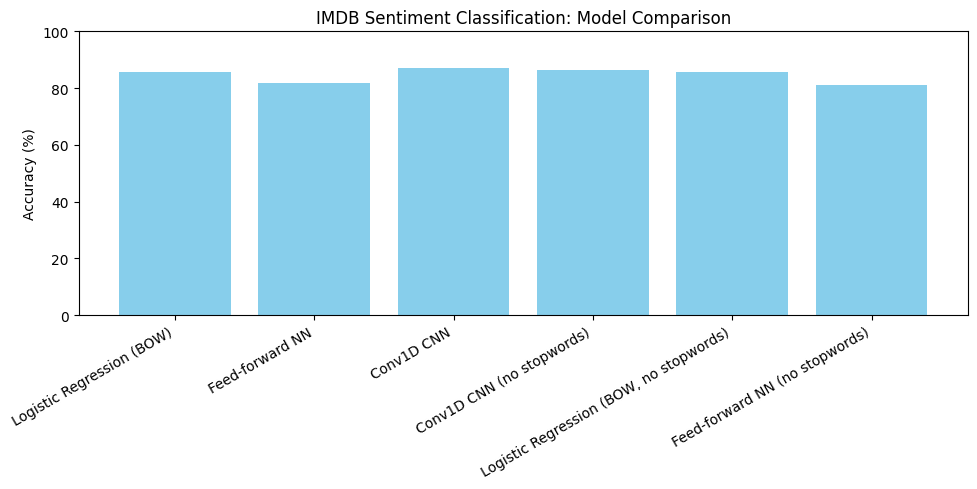

In [14]:
import pandas as pd

import matplotlib.pyplot as plt

# Collect results from previous cells
results = [
    {
        "Model": "Logistic Regression (BOW)",
        "Accuracy (%)": acc_lr,
    },
    {
        "Model": "Feed-forward NN",
        "Accuracy (%)": acc * 100,
    },
    {
        "Model": "Conv1D CNN",
        "Accuracy (%)": acc_cnn * 100,
    },
    {
        "Model": "Conv1D CNN (no stopwords)",
        "Accuracy (%)": acc_ns * 100,
    },
    {
        "Model": "Logistic Regression (BOW, no stopwords)",
        "Accuracy (%)": acc_lr_ns,
    },
    {
        "Model": "Feed-forward NN (no stopwords)",
        "Accuracy (%)": acc_ff_ns * 100,
    },
]

# Create DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

# Bar graph
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["Accuracy (%)"], color='skyblue')
plt.ylabel("Accuracy (%)")
plt.title("IMDB Sentiment Classification: Model Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()